In [2]:
'''Installing Necessary Libraries'''
from pandas import Series, DataFrame
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure 
%pylab inline

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.palettes import Set3, GnBu3, OrRd3, RdYlGn, Reds, Paired
from bokeh.transform import cumsum, dodge
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.core.properties import value
from bokeh.models.widgets import Tabs
from bokeh.io import export_png


plot = figure(plot_width=600, plot_height=400, tools='pan,box_zoom')
output_notebook()


Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

# Exploring The Data

### Are there significant differences in the general products countries eat?



In order to analzye the general nutrition characteristics of the food products, 
it will be helpful to know the amount of energy, saturated fat, trans fat, fiber,
sodium, sugars, and protein contained in each product. Let's only select rows 
where this information is not missing. 

In [16]:
df = pd.read_csv('final_food_data.csv') #reading in the data
df['country'] = df['country'].replace(['United Kingdom','United States'],['UK','US']) #renaming countries concisely
nutrients = df.dropna(subset=['saturated-fat_100g','fiber_100g','sugars_100g','proteins_100g','sodium_100g'], how='any')

Let's also remove any outliers. We are interested in comparing the general food products so want to remove any products that will skew this analysis
Outliers are defined as being 3 standard deviations from the normalized mean

In [17]:
def remove_outliers(df, out_cols, T=1.5, verbose=True):
    # Copy of df
    new_df = df.copy()
    init_shape = new_df.shape
    # For each column
    for c in out_cols:
        q1 = new_df[c].quantile(.25)
        q3 = new_df[c].quantile(.75)
        col_iqr = q3 - q1
        col_max = q3 + T * col_iqr
        col_min = q1 - T * col_iqr
        # Filter data without outliers and ignoring nan
        filtered_df = new_df[(new_df[c] <= col_max) & (new_df[c] >= col_min)]
        if verbose:
            n_out = new_df.shape[0] - filtered_df.shape[0] 
            print(f" Columns {c} had {n_out} outliers removed")
        new_df = filtered_df
            
    if verbose:
        # Print shrink percentage
        lines_red = df.shape[0] - new_df.shape[0]
        print(f"Data reduced by {lines_red} lines, or {lines_red/df.shape[0]*100:.2f} %")
    return new_df

outliers = ['saturated-fat_100g','fiber_100g','sugars_100g','proteins_100g','sodium_100g']
df = remove_outliers(df=nutrients,out_cols=outliers)

 Columns saturated-fat_100g had 15968 outliers removed
 Columns fiber_100g had 13458 outliers removed
 Columns sugars_100g had 12915 outliers removed
 Columns proteins_100g had 7191 outliers removed
 Columns sodium_100g had 8148 outliers removed
Data reduced by 57680 lines, or 26.70 %


#### Let's begin by looking into the number of products we have per country:

In [74]:
chart_colors = ['#BE9EC9', '#feb236', '#006E6D',
                '#d64161', '#F1EA7F', '#6b5b95',
                '#EC9787', ' #BD3D3A', '#D5AE41', '#00A591','#7F4145']

country = df['country'].value_counts().rename_axis('country').to_frame('counts')
country['angle'] = country['counts']/country['counts'].sum() * 2*pi
country['color'] = Set3[len(country)]

p = figure(plot_height=350, title="Number of Products by Country", toolbar_location=None,
           tools="hover", tooltips="@country: @counts", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='country', source=country)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

export_png(p, filename="plot1.png")

'C:\\Users\\india\\Documents\\Projects\\plot1.png'

The US and France definitely dominate this dataset. 

#### How does the general nutritional content of the food products differ by country? 

In [75]:
#focusing on mean nutrient value per product by country 
nutr = df.groupby('country',as_index=False)[['sugars_100g','saturated-fat_100g','sodium_100g','proteins_100g','fiber_100g']].agg('mean')
data = nutr.to_dict(orient='list')
country = nutr['country'].tolist()

#get max possible value of plotted columns with some offset
p = figure(x_range=country, y_range=(0, nutr[['sugars_100g','saturated-fat_100g','sodium_100g']].values.max() + 3), 
           plot_height=250, title="Nutritional Content By Country", plot_width = 800,
           toolbar_location=None, tools="", y_axis_label = 'Mean Amount Per 100g')

p.vbar(x=dodge('country', -0.1, range=p.x_range), top='sugars_100g', width=0.4, source=ColumnDataSource(data),
       color=Set3[8][7], legend_label="sugars")

p.vbar(x=dodge('country', 0, range=p.x_range), top='saturated-fat_100g', width=0.4, source=ColumnDataSource(data),
       color=Set3[4][2], legend_label="saturated fat")

p.vbar(x=dodge('country', 0.1, range=p.x_range), top='sodium_100g', width=0.4, source=ColumnDataSource(data),
       color=Set3[4][3], legend_label="sodium")

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"


#get max possible value of plotted columns with some offset
h = figure(x_range=country, y_range=(0, nutr[['proteins_100g','fiber_100g']].values.max() + 3), 
           plot_height=250, plot_width=800,
           toolbar_location=None, tools="", y_axis_label = 'Mean Amount Per 100g')

h.vbar(x=dodge('country', 0.1, range=p.x_range), top='proteins_100g', width=0.4, source=ColumnDataSource(data),
       color='#80ced6', legend_label='protein')

h.vbar(x=dodge('country',  0.2,  range=p.x_range), top='fiber_100g', width=0.4, source=ColumnDataSource(data),
       color='#d5f4e6',legend_label = "fiber")


h.x_range.range_padding = 0.1
h.xgrid.grid_line_color = None
h.legend.location = "top_left"
h.legend.orientation = "horizontal"

show(p)
show(h)

export_png(p, filename="plot2.png")
export_png(h, filename="plot3.png")

'C:\\Users\\india\\Documents\\Projects\\plot3.png'

Sugar has fairly detrimental affects on health. It can lead to weight gain, increased risk of type 2 Diabetes, food addictions, and chronic digestive issues. Saturated fats can causes increases in harmful LDL cholesterol levels, create inflammation, and contribute to insulin resistance. Excess sodium can lead to elevated blood pressure and cause varying health problems. 

Protein is essential within a diet as it is used by our bodies to build and repair tissues. Our body is unable to store protein and needs relatively large quantities of it. Fiber aids our bodies in regulating digestion and lowers cholesterol levels. It is recommended to eat foods high in fiber to help achieve a healthy weight. 

In general, most countries products tend to have a fairly high average sugar content per product with the US, Canada, and Belgium taking the lead. Russia has both the highest average protein and saturated fat content per 100g. 

*Sources at Bottom of Report*

Sources: 
https://www.webmd.com/diabetes/features/how-sugar-affects-your-body
https://www.heart.org/en/healthy-living/healthy-eating/eat-smart/fats/saturated-fats
https://www.mayoclinic.org/healthy-lifestyle/nutrition-and-healthy-eating/in-depth/fiber/art-20043983


### Let's Look At The Popularity of Alternative Diets By Country

If a product fits a vegetarian diet, than it contains no animal meat products. If it fits a vegan diet, it contains no animal or dairy products. Foods that are vegan are also vegetarian.

In the data quality file, I used categorized the foods by their diet type. Let's use these tags to discovery which countries have preferences for the different diets. 

In [25]:
diets = df[df['Special Diet']!= 'Not Specified']

#gives us proportion of popularity of each diet to normalize for amount of products per country
diets2 = pd.crosstab(diets['country'],diets['Special Diet']).apply(lambda r: r/r.sum(), axis=1)

In [76]:

from bokeh.models.ranges import FactorRange
p = figure(title="Special Diet Popularity",
           y_axis_label='Country', x_axis_label='Proportion of Products',
           y_range = FactorRange(factors=list(diets2.index)),
           plot_height=600, plot_width=800)

p.hbar(y=diets2.index, left=0, right=diets2['Dairy Product'], height=0.2, color='#ff6f69', legend_label='Dairy')
p.hbar(y=diets2.index, left=diets2['Dairy Product'], right=diets2['Meat Product'], height=0.2, color='#ffcc5c', legend_label='Meat')
p.hbar(y=diets2.index, left=diets2['Meat Product'], right=diets2['Vegan'], height=0.2, color='#96ceb4', legend_label='Vegan')
p.hbar(y=diets2.index, left=diets2['Vegan'], right=diets2['Vegetarian'], height=0.2, color='#ffeead', legend_label='Vegetarian')


show(p)
export_png(p, filename="plot5.png")

'C:\\Users\\india\\Documents\\Projects\\plot5.png'

The majority of Spain's products in this dataset are vegetarian and no other country comes close. Pretty much all of Russia's products in this dataset are meat products. The US, Italy, and Belgium also offer a lot of meat products while Germany, Australia, Spain, and the UK have very few if any meat products. Australia and France consume a notable number of vegan products.  


#### Which countries offer the most organic products?

In [22]:
import re

df['labels_en'] = df['labels_en'].astype(str)
def find_organic(s):
    if ('organic' in s['labels_en'].lower()):
        return 1
    else:
        return 0
df['organic'] = df.apply(lambda row: find_organic(row), axis=1)


In [77]:
country = df['country'].tolist()

org = pd.crosstab(df['country'],df['organic']).apply(lambda r: r/r.sum(), axis=1)

from bokeh.models.ranges import FactorRange
p = figure(title="Organic Products By Country",
           x_axis_label='Country', y_axis_label='Proportion of Products',
           x_range = FactorRange(factors=list(org.index)),
           plot_height=600, plot_width=800)

p.vbar(x=org.index, bottom=0, top=org[0], width=0.2, color='#f7cac9', legend_label='Organic')
p.vbar(x=org.index, bottom=org[0], top=org[1], width=0.2, color='#92a8d1', legend_label='Non-Organic')

show(p)
export_png(p, filename="plot6.png")



'C:\\Users\\india\\Documents\\Projects\\plot6.png'

The European countries have the greatest proportion of organic products in this dataset. About 1/3 of all of Germany's products are sourced organically. 

### What ingredients are shared between the countries with the most products? Looking into US, France, Switzerland, Spain, and Germany


In [37]:
#cleaning ingredients by making them all lower case and removing punctuation
def clean_ing1(s):
    s =str(s)
    s = s.lower()
    s = re.sub('[^a-z,\s]+', '', s)
    return s

df['ingredients'] = df['ingredients_text'].map(clean_ing1)

#assigning each individual ingredient to its own line
clean_ing = df.assign(ingredients_single=df['ingredients'].str.split(',')).explode('ingredients_single')

In [39]:
from translate import Translator
translator= Translator(to_lang="English")

def clean(lst):
    a = set()
    for i in lst:
        i.lstrip(' ').rstrip(' ')
        if i != '':
            translatedText = translator.translate(i)
            a.add(translatedText)
    return a


In [41]:
a = clean_ing[clean_ing['country'] == 'Australia']
top_a = a['ingredients_single'].value_counts().nlargest(11)
top_a = top_a.index.tolist()
top_a = clean(top_a)

In [46]:
f = clean_ing[clean_ing['country'] == 'France']
top_f = f['ingredients_single'].value_counts().nlargest(11)
top_f = top_f.index.tolist()
top_f = clean(top_f)

us = clean_ing[clean_ing['country'] == 'US']
top_us = us['ingredients_single'].value_counts().nlargest(11)
top_us= top_us.index.tolist()
top_us = clean(top_us)
  
s = clean_ing[clean_ing['country'] == 'Switzerland']
top_s = s['ingredients_single'].value_counts().nlargest(11)
top_s= top_s.index.tolist()
top_s = clean(top_s)

sp = clean_ing[clean_ing['country'] == 'Spain']
top_sp = sp['ingredients_single'].value_counts().nlargest(11)
top_sp= top_sp.index.tolist()
top_sp = clean(top_sp)

g = clean_ing[clean_ing['country']=='Germany']
top_g= g['ingredients_single'].value_counts().nlargest(11)
top_g = top_g.index.tolist()
top_g = clean(top_g)


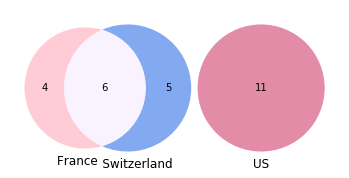

In [70]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

plt = venn3([top_us,top_f,top_s],set_labels = ('US','France    ','     Switzerland'), set_colors=('palevioletred','pink','cornflowerblue'),alpha=0.8)
matplotlib.pyplot.savefig('venn1.png')

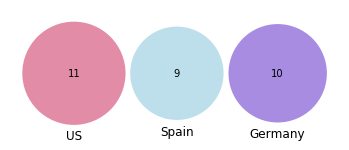

In [71]:
plt = venn3([top_us,top_sp,top_g],set_labels = ('US','Spain','Germany'), set_colors=('palevioletred','lightblue','mediumpurple'),alpha=0.8)
matplotlib.pyplot.savefig('venn2.png')

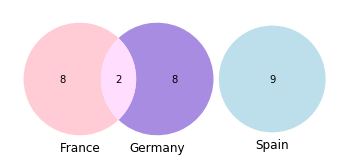

In [72]:
plt = venn3([top_sp,top_f,top_g],set_labels = ('Spain','France','Germany'), set_colors=('lightblue','pink','mediumpurple'),alpha=0.8)
matplotlib.pyplot.savefig('venn3.png')

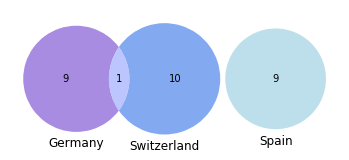

In [73]:
plt = venn3([top_s,top_sp,top_g],set_labels = ('Switzerland','Spain','Germany'), set_colors=('cornflowerblue','lightblue','mediumpurple'),alpha=0.8)
matplotlib.pyplot.savefig('venn4.png')